$SquareWell-Video$

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 24 14:29:40 2024

@author: dell
"""

from scipy.special import spherical_jn as jn
from scipy.special import spherical_yn as yn
#from scipy.special import lambertw as lamb
from scipy.misc import derivative
from scipy.interpolate import CubicSpline as CS
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
from scipy.integrate import solve_ivp

'''def Vpot(r,V0,a):
    if r <= a and r >=0.: 
        return -V0
    else:
        return 0.'''
def Vpot(r, V0, a):
    a = 2*a
    smooth = 10.
    return V0 * np.tanh((r - a / 2) * smooth) / 2 - V0/2

#def rpos():
    
#    return a  #np.sqrt(np.log(-V0/Eval))

def odeeqns(r, y, Mr, l, El, V0,a):
    theta, omega = y
    return [omega, -2.*Mr*(El-Vpot(r,V0,a))*theta]

Varray = np.linspace(1.0, 2.0, 270)                  #np.loadtxt("F:/Spyder/potential_depths.dat")
y0=[0.,1.]
r=np.linspace(0.001,12.,1500)
rlen = len(r)
Mr=0.95
l=0
V0=np.pi**2/8
r_span = (0.001,12.)
a = 1.0
rbsc = []
vbsc = []
Elvls = []
for iEdel in np.linspace(-40.,0.,num=200):
    El=iEdel/800.+0.001
    Elvls.append(El)
    pmom = np.lib.scimath.sqrt(2*Mr*El)
    rbsc.append(np.real(1j*np.power(pmom,2*l+1)))
    vbsc.append(np.real(1j*np.power(-pmom,2*l+1)))
    
Eplvls = np.linspace(0.,100.,num=200)/800.+0.000001

rbsc = np.array(rbsc)
vbsc = np.array(vbsc)
Elvls = np.array(Elvls)

def kmat(V0):
    ktilde = []
    for iEdel in np.linspace(-40.,0.,num=200):
        El=iEdel/800.+0.001
        usol = solve_ivp(odeeqns, r_span,  y0, t_eval= r, args=(Mr, l, El, V0,a),)

        #ufunc=CS(usol.t, -usol.y[0])
        Rfunc=CS(usol.t[1:], np.lib.scimath.log(usol.y[0][1:]/usol.t[1:])).derivative()

        #Rvals = Rfunc(usol.t)
        ra = 8.
        pmom = np.lib.scimath.sqrt(2*Mr*El)
        def jnfn(x):
            return jn(l, pmom*x)
        def ynfn(x):
            return yn(l, pmom*x)

        num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
        den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)
        ktilde.append(np.real(np.power(pmom,2*l+1)*num/den))
               
    rpsin = CS(Elvls, np.array(ktilde)-rbsc)
    vpsin = CS(Elvls, np.array(ktilde)-vbsc)
    polE = -10. 
    polp = -10.
    uwfnr = 1000.*np.ones(1500)
    uwfny = 1000.*np.ones(1500)

    penh = 1000.*np.ones((len(Eplvls)))
    for sols in rpsin.roots():
        if sols<0:
            if sols>polE:
                polE = sols
                polp = np.real(1j*np.lib.scimath.sqrt(2*Mr*polE))
                uwfn = solve_ivp(odeeqns, r_span, y0, t_eval= r, args=(Mr, l, polE, V0,a),)
                uwfnr = np.array(uwfn.t)
                uwfny = np.array(uwfn.y[0])
                penh = np.sqrt(np.power(2*Mr*Eplvls,3))/np.power(rpsin(Eplvls),2)
    for sols in vpsin.roots():
        if sols<0:
            if sols>polE:
                polE = sols
                polp = np.real(-1j*np.lib.scimath.sqrt(2*Mr*polE))
                uwfn = solve_ivp(odeeqns, r_span,  y0,t_eval= r, args=(Mr, l, polE, V0,a),)
                penh = np.sqrt(np.power(2*Mr*Eplvls,3))/np.power(vpsin(Eplvls),2)

    return ktilde, polp, polE, uwfnr, uwfny, penh
          


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
fig.suptitle('Pole trajectory in a potential '+r"$V=-V_0 in [0,a]$", fontsize=21)


def AnimFunction(frame):
    stepval=0.002
    Vvals = np.array([Vpot(ix,Varray[frame],a) for ix in r])
    Kvals, poE, pop, uwfnr, uwfny, penh = kmat(Varray[frame])

    ax1.clear()
    ax1.set_ylim(-2.0,0.3)
    ax1.set_xlim(0, 4.)
    ax1.set_xlabel("r",family='sans-serif',fontsize=24,fontstyle='italic')
    ax1.set_ylabel("V",family='sans-serif',fontsize=24,fontstyle='italic')
    ax1.tick_params(axis="x", labelsize=15)
    ax1.tick_params(axis="y", labelsize=15)
    if poE<-0.01:
        ax1.hlines(poE, 0., a , colors="orange", linestyle="-",)  
    elif poE>0.01:
        ax1.hlines(-poE, 0., a, colors="magenta", linestyle="-",)  
    ax1.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
    ax1.plot(r, Vvals, lw=2.5, color="blue")

    ax2.clear()
    ax2.set_ylim([-0.4,0.4])
    ax2.set_xlim([-0.05,0.001])
    ax2.set_xlabel(r"$p^2$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax2.set_ylabel(r"$p~cot\delta_0$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax2.tick_params(axis="x", labelsize=15)
    ax2.tick_params(axis="y", labelsize=15)
    ax2.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
    ax2.axvline(x=0.0, color='0.0', linestyle='-',alpha=0.5)
    ax2.plot(Elvls, rbsc, color="orange", linestyle="dashed", lw=2.5)
    ax2.plot(Elvls, vbsc, color="cyan", linestyle="dashed", lw=2.5)
    ax2.plot(Elvls, Kvals, lw=2.5, color="red")
    if poE<-0.001:
        ax2.scatter(np.array([pop]), np.array([poE]), c="orange", s=100, alpha=0.8) 
    elif poE>0.001:
        ax2.scatter(np.array([pop]), np.array([poE]), c="magenta", s=100, alpha=0.8) 

    ax3.clear()
    ax3.set_ylim(-0.1,1.5)
    ax3.set_xlim(0, 4.)
    ax3.set_xlabel("$r$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax3.set_ylabel("$u$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax3.tick_params(axis="x", labelsize=15)
    ax3.tick_params(axis="y", labelsize=15)
    ax3.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
    ax3.axvline(x=0.0, color='0.0', linestyle='-',alpha=0.5)
    if poE<-0.001:
        ax3.plot(uwfnr, uwfny, lw=2.5, color="orange", linestyle="dashdot")
    elif poE>0.001:
        ax3.plot(uwfnr, uwfny, lw=2.5, color="magenta", linestyle="dashdot")
                
    ax4.clear()
    ax4.set_ylim(-0.01,0.2)
    ax4.set_xlim(-0.12, 0.05)
    ax4.set_xlabel(r"$E_{cm}$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax4.set_ylabel(r"$p|t|^2$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax4.tick_params(axis="x", labelsize=15)
    ax4.tick_params(axis="y", labelsize=15)
    ax4.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
    ax4.axvline(x=0.0, color='0.0', linestyle='-',alpha=0.5)
    if poE<-0.001:
        ax4.scatter(np.array([poE]), np.array([0.0]), c="orange", s=100, alpha=0.8) 
        ax4.plot(Eplvls, penh, lw=2.5, color="red")
    elif poE>0.001:
        ax4.plot(Eplvls, penh, lw=2.5, color="red")
        ax4.scatter(np.array([-poE]), np.array([0.0]), c="magenta", s=100, alpha=0.8)   
    
anim_created = FuncAnimation(fig, AnimFunction, frames=150, interval=50)#, save_count=150)
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

fig.tight_layout()

anim_created.save('Square_well_tanI.mp4')
plt.close()

C:\Users\dell\AppData\Local\Temp\ipykernel_52080\1315877423.py:79: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
C:\Users\dell\AppData\Local\Temp\ipykernel_52080\1315877423.py:80: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)


C:\Users\dell\AppData\Local\Temp\ipykernel_52080\1315877423.py:79: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
C:\Users\dell\AppData\Local\Temp\ipykernel_52080\1315877423.py:80: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)


$Plots$

In [4]:
from scipy.special import spherical_jn as jn
from scipy.special import spherical_yn as yn
#from scipy.special import lambertw as lamb
from scipy.misc import derivative
from scipy.interpolate import CubicSpline as CS
import matplotlib.pyplot as plt
import numpy as np
#from matplotlib.animation import FuncAnimation
#from IPython import display
from scipy.integrate import solve_ivp

In [5]:
'''def Vpot(r,V0,a):
    if r <= a and r >=0.: 
        return -V0
    else:
        return 0.'''
def Vpot(r, V0, a):
    a = 2*a
    smooth = 10.
    return V0 * np.tanh((r - a / 2) * smooth) / 2 - V0/2

def odeeqns(r, y, Mr, l, El, V0,a):
    theta, omega = y
    return [omega, -2.*Mr*(El-Vpot(r,V0,a))*theta]


In [6]:
Varray = np.linspace(1.0, 2.0, 270)                  #np.loadtxt("F:/Spyder/potential_depths.dat")
rmax = 12.
y0=[0.,1.]
r=np.linspace(0.001,rmax,1500)
rlen = len(r)
Mr=0.95
l=0
r_span = (0.001,rmax)

In [136]:
#V0=np.pi**2/8
V0 = Varray[135]
a = 1.0

In [137]:
ktilde = []
rbsc = []
vbsc = []
Elvls = []
for iEdel in np.linspace(-40.,0.,num=200):
    El=iEdel/800.+0.001
    Elvls.append(El)
    pmom = np.lib.scimath.sqrt(2*Mr*El)
    rbsc.append(np.real(1j*np.power(pmom,2*l+1)))
    vbsc.append(np.real(1j*np.power(-pmom,2*l+1)))
    
    usol = solve_ivp(odeeqns, r_span,  y0, t_eval= r, args=(Mr, l, El, V0,a),)

    #ufunc=CS(usol.t, -usol.y[0])
    Rfunc=CS(usol.t[1:], np.lib.scimath.log(usol.y[0][1:]/usol.t[1:])).derivative()

    #Rvals = Rfunc(usol.t)
    ra = 8.
    pmom = np.lib.scimath.sqrt(2*Mr*El)
    def jnfn(x):
        return jn(l, pmom*x)
    def ynfn(x):
        return yn(l, pmom*x)

    num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
    den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)
    ktilde.append(np.real(np.power(pmom,2*l+1)*num/den))
               
Eplvls = np.linspace(0.,100.,num=200)/800.+0.000001

rbsc = np.array(rbsc)
vbsc = np.array(vbsc)
Elvls = np.array(Elvls)

rpsin = CS(Elvls, np.array(ktilde)-rbsc)
vpsin = CS(Elvls, np.array(ktilde)-vbsc)
polE = -10. 
polp = -10.
uwfnr = 1000.*np.ones(1500)
uwfny = 1000.*np.ones(1500)
penh = 1000.*np.ones((len(Eplvls)))

for sols in rpsin.roots():
    if sols<0:
        if sols>polE:
            polE = sols
            polp = np.real(1j*np.lib.scimath.sqrt(2*Mr*polE))
            uwfn = solve_ivp(odeeqns, r_span, y0, t_eval= r, args=(Mr, l, polE, V0,a),)
            uwfnr = np.array(uwfn.t)
            uwfny = np.array(uwfn.y[0])
            penh = np.sqrt(np.power(2*Mr*Eplvls,3))/np.power(rpsin(Eplvls),2)
for sols in vpsin.roots():    
    if sols<0:
        if sols>polE:
            polE = sols
            polp = np.real(-1j*np.lib.scimath.sqrt(2*Mr*polE))
            uwfn = solve_ivp(odeeqns, r_span,  y0,t_eval= r, args=(Mr, l, polE, V0,a),)
            penh = np.sqrt(np.power(2*Mr*Eplvls,3))/np.power(vpsin(Eplvls),2)
    


C:\Users\dell\AppData\Local\Temp\ipykernel_42608\2666934616.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
C:\Users\dell\AppData\Local\Temp\ipykernel_42608\2666934616.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)


V0 =  1.5018587360594795 , Polp =  -0.17983132108247288


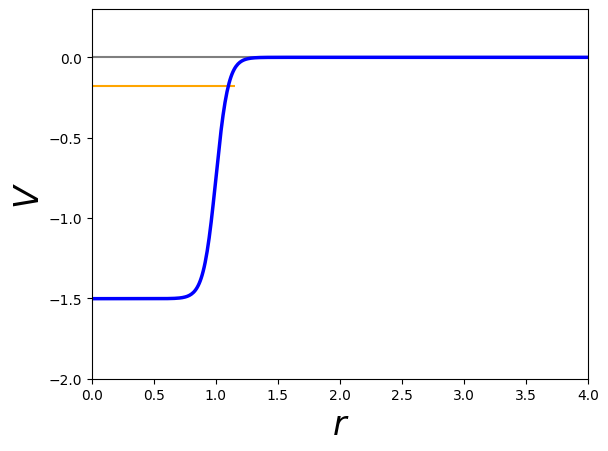

In [138]:
plt.ylim(-2.0,0.3)
plt.xlim(0, 4.)
plt.xlabel("r",family='sans-serif',fontsize=24,fontstyle='italic')
plt.ylabel("V",family='sans-serif',fontsize=24,fontstyle='italic')
if polp<-0.001:
    plt.hlines(polp, 0., a+0.15, colors="orange", linestyle="-",)  # rpos(polp,V0),'''
elif polp>0.001:
    plt.hlines(-polp, 0., a+0.15, colors="magenta", linestyle="-",)  #''' rpos(-polp,V0),'''
plt.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
plt.plot(r, Vpot(r,V0,a), lw=2.5, color="blue")
print("V0 = " ,V0 , ", Polp = ", polp)

-0.017020686338035503


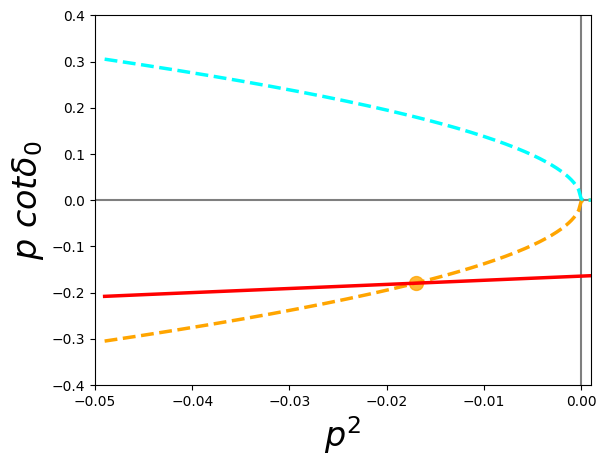

In [139]:
plt.ylim([-0.4,0.4])
plt.xlim([-0.05,0.001])
plt.xlabel(r"$p^2$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.ylabel(r"$p~cot\delta_0$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
plt.axvline(x=0.0, color='0.0', linestyle='-',alpha=0.5)
plt.plot(Elvls, rbsc, color="orange", linestyle="dashed", lw=2.5)
plt.plot(Elvls, vbsc, color="cyan", linestyle="dashed", lw=2.5)
plt.plot(Elvls, ktilde, lw=2.5, color="red")
if polp<-0.01:
    plt.scatter(np.array([polE]), np.array([polp]), c="orange", s=100, alpha=0.8) 
elif polp>0.01:
    plt.scatter(np.array([polE]), np.array([polp]), c="magenta", s=100, alpha=0.8) 
print(polE)

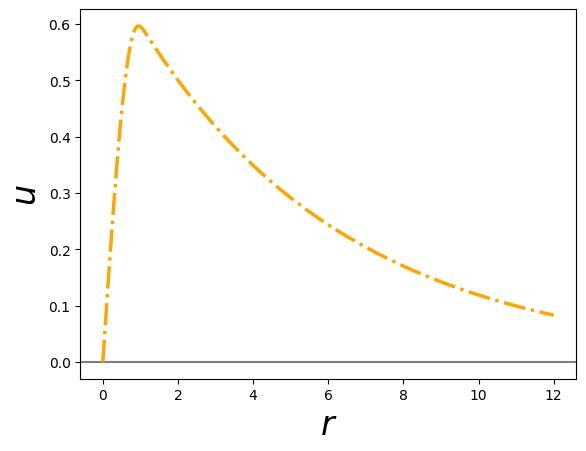

In [140]:
#plt.ylim(-0.1,2.)
#plt.xlim(0, 20.)
plt.xlabel("$r$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.ylabel("$u$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
if polp<-0.001:
    plt.plot(uwfn.t, uwfn.y[0], lw=2.5, color="orange", linestyle="dashdot")
elif polp>0.001:
    plt.plot(uwfn.t, uwfn.y[0], lw=2.5, color="magenta", linestyle="dashdot")

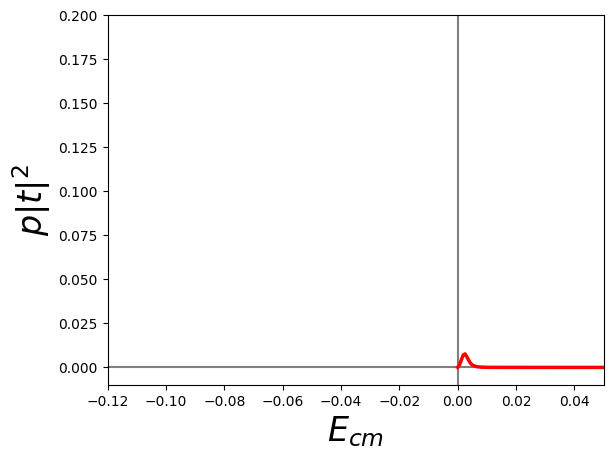

In [141]:
plt.ylim(-0.01,0.2)
plt.xlim(-0.12, 0.05)
plt.xlabel(r"$E_{cm}$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.ylabel(r"$p|t|^2$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
plt.axvline(x=0.0, color='0.0', linestyle='-',alpha=0.5)
if polp<-0.001:
    plt.scatter(np.array([polp]), np.array([0.0]), c="orange", s=100, alpha=0.8) 
    plt.plot(Eplvls, penh, lw=2.5, color="red")
elif polp>0.001:
    plt.plot(Eplvls, penh, lw=2.5, color="red")
    plt.scatter(np.array([-polp]), np.array([0.0]), c="magenta", s=100, alpha=0.8)

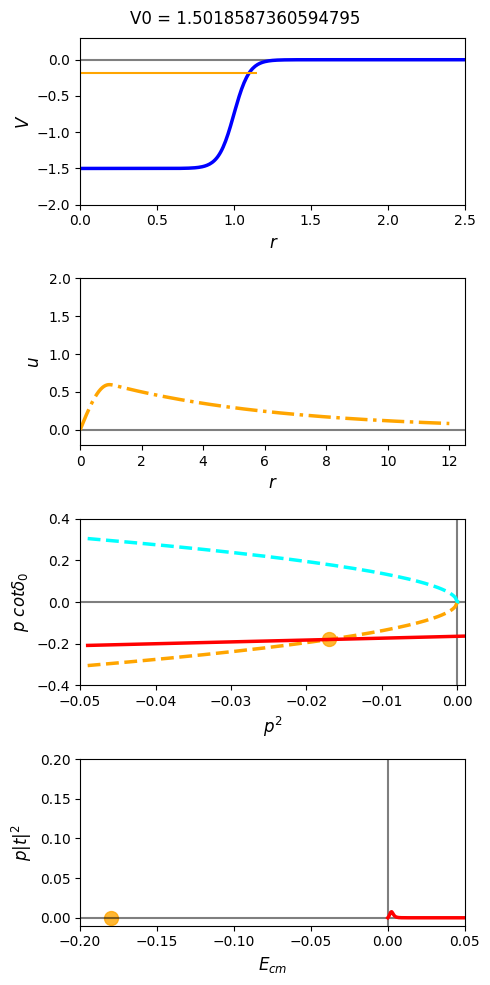

In [142]:
fig, axs = plt.subplots(4, 1, figsize=(5, 10))


axs[0].set_ylim(-2.0, 0.3)
axs[0].set_xlim(0, 2.5)
axs[0].set_xlabel("r", family='sans-serif', fontsize=12, fontstyle='italic')
axs[0].set_ylabel("V", family='sans-serif', fontsize=12, fontstyle='italic')
axs[0].axhline(y=0.0, color='0.0', linestyle='-', alpha=0.5)
axs[0].plot(r, Vpot(r, V0,a), lw=2.5, color="blue")
if polp < -0.001:
    axs[0].hlines(polp, 0., a+0.15, colors="orange", linestyle="-")
elif polp > 0.001:
    axs[0].hlines(-polp, 0., a+0.15, colors="magenta", linestyle="-")
#axs[0].text(3, 0.25, "V0 = " + str(V0) + ", Polp = " + str(polp))


axs[1].set_ylim(-0.2, 2.)
axs[1].set_xlim(0, 12.5)
axs[1].set_xlabel("$r$", family='sans-serif', fontsize=12, fontstyle='italic')
axs[1].set_ylabel("$u$", family='sans-serif', fontsize=12, fontstyle='italic')
axs[1].axvline(x=0.0, color='0.0', linestyle='-', alpha=0.5)
axs[1].axhline(y=0.0, color='0.0', linestyle='-', alpha=0.5)
if polp < -0.001:
    axs[1].plot(uwfn.t, uwfn.y[0], lw=2.5, color="orange", linestyle="dashdot")
elif polp > 0.001:
    axs[1].plot(uwfn.t, uwfn.y[0], lw=2.5, color="magenta", linestyle="dashdot")


axs[2].set_ylim(-0.4, 0.4)
axs[2].set_xlim(-0.05, 0.001)
axs[2].set_xlabel(r"$p^2$", family='sans-serif', fontsize=12, fontstyle='italic')
axs[2].set_ylabel(r"$p~cot\delta_0$", family='sans-serif', fontsize=12, fontstyle='italic')
axs[2].axhline(y=0.0, color='0.0', linestyle='-', alpha=0.5)
axs[2].axvline(x=0.0, color='0.0', linestyle='-', alpha=0.5)
axs[2].plot(Elvls, rbsc, color="orange", linestyle="dashed", lw=2.5)
axs[2].plot(Elvls, vbsc, color="cyan", linestyle="dashed", lw=2.5)
axs[2].plot(Elvls, ktilde, lw=2.5, color="red")
if polp < -0.01:
    axs[2].scatter(np.array([polE]), np.array([polp]), c="orange", s=100, alpha=0.8)
elif polp > 0.01:
    axs[2].scatter(np.array([polE]), np.array([polp]), c="magenta", s=100, alpha=0.8)


axs[3].set_ylim(-0.01, 0.2)
axs[3].set_xlim(-0.2, 0.05)
axs[3].set_xlabel(r"$E_{cm}$", family='sans-serif', fontsize=12, fontstyle='italic')
axs[3].set_ylabel(r"$p|t|^2$", family='sans-serif', fontsize=12, fontstyle='italic')
axs[3].axhline(y=0.0, color='0.0', linestyle='-', alpha=0.5)
axs[3].axvline(x=0.0, color='0.0', linestyle='-', alpha=0.5)
if polp < -0.001:
    axs[3].scatter(np.array([polp]), np.array([0.0]), c="orange", s=100, alpha=0.8)
    axs[3].plot(Eplvls, penh, lw=2.5, color="red")
elif polp > 0.001:
    axs[3].plot(Eplvls, penh, lw=2.5, color="red")
    axs[3].scatter(np.array([-polp]), np.array([0.0]), c="magenta", s=100, alpha=0.8)


fig.suptitle("V0 = " + str(V0) , fontsize=12) #+ ", Polp = " + str(polp)

plt.tight_layout()
plt.savefig("plot_V0_" + str(V0) + ".png")
plt.show()